# In-depth analysis: Prediction of booking scores 

Now, using all the features possible, we will try to inference relations between them to used for the prediction of booking scores.

In [1]:
import gzip
import json
import csv
import pandas as pd
import numpy as np
from scipy import stats
from functools import reduce
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
listing = pd.read_csv('../Data/raw/listings.csv.gz', 
                      compression='gzip',
                      error_bad_lines=False, 
                      low_memory=False)

In [4]:
listing.columns

Index(['id', 'listing_url', 'scrape_id', 'last_scraped', 'name', 'summary',
       'space', 'description', 'experiences_offered', 'neighborhood_overview',
       ...
       'instant_bookable', 'is_business_travel_ready', 'cancellation_policy',
       'require_guest_profile_picture', 'require_guest_phone_verification',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month'],
      dtype='object', length=106)

Seaborn package offers the function `pairplot` that allows to create scatterplots of all the variables used as input. If you enter the name of your dataset, you get the visual relation between all the variables and you can start your analysis quickly. As we saw before, this dataset contains 106 columns in different formats. A lot of them neither categorical or numerical. Thus, we select carefully the columns that could it makes sense for the next analysis. How? Using as reference the previos analysis.

In this section we are using df_dataset that select only a couple of columns:

In [5]:
list_columns = ['id',
                'host_id',
                'host_since', 
                'host_response_time', 
                'host_response_rate', 
                'host_is_superhost',
                'neighbourhood_cleansed', 
                'room_type',
                'property_type', 
                'accommodates', 
                'bathrooms', 
                'bedrooms', 
                'beds', 
                'bed_type', 
                'amenities', 
                'price', 
                'extra_people', 
                'minimum_nights',
                'maximum_nights',
                'alendar_updated',
                'has_availability',
                'availability_30',
                'availability_60',
                'availability_90',
                'availability_365',
                'number_of_reviews',
                'number_of_reviews_ltm',
                'first_review',
                'last_review',
                'review_scores_rating',
                'review_scores_accuracy',
                'review_scores_cleanliness',
                'review_scores_checkin',
                'review_scores_communication',
                'review_scores_location',
                'review_scores_value',
                'calculated_host_listings_count',
                'calculated_host_listings_count_entire_homes',
                'calculated_host_listings_count_private_rooms',
                'calculated_host_listings_count_shared_rooms',
                'reviews_per_month']

In [6]:
df_dataset = listing.loc[:, list_columns].reindex()

/Users/daniela/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [7]:
df_dataset.head()

,id,host_id,host_since,host_response_time,host_response_rate,host_is_superhost,neighbourhood_cleansed,room_type,property_type,accommodates,...,review_scores_cleanliness,review_scores_checkin,review_scores_communication,review_scores_location,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,2818,3159,2008-09-24,within an hour,100%,t,Oostelijk Havengebied - Indische Buurt,Private room,Apartment,2,...,10.0,10.0,10.0,9.0,10.0,1,0,1,0,2.13
1,20168,59484,2009-12-02,within an hour,100%,f,Centrum-Oost,Private room,Townhouse,2,...,10.0,10.0,10.0,10.0,9.0,2,0,2,0,2.57
2,25428,56142,2009-11-20,within an hour,100%,f,Centrum-West,Entire home/apt,Apartment,3,...,10.0,10.0,10.0,10.0,10.0,2,2,0,0,0.13
3,27886,97647,2010-03-23,within an hour,100%,t,Centrum-West,Private room,Houseboat,2,...,10.0,10.0,10.0,10.0,10.0,1,0,1,0,2.14
4,28871,124245,2010-05-13,within an hour,100%,t,Centrum-West,Private room,Apartment,2,...,10.0,10.0,10.0,10.0,10.0,3,0,3,0,2.81


Transforming non-numerical `host_response_rate` to numerical:

In [8]:
def str_rate2int(rate):
    if type(rate) is str:
        return float(rate.replace("%", ""))
    else:
        return rate 

In [9]:
df_dataset['host_response_rate_float'] = df_dataset.host_response_rate.apply(str_rate2int)

In [10]:
def str2boolean(row):
    if row == 't':
        return 1
    elif row == 'f':
        return 0
    else:
        return np.nan

In [11]:
df_dataset['superhost'] = df_dataset.host_is_superhost.apply(str2boolean)

In [12]:
def price2float(string_price):
    return float(string_price.split('.')[0].replace('$', '').replace(',', ''))

In [13]:
df_dataset['price_float'] = df_dataset.price.apply(price2float)

In [14]:
df_dataset['extra_people_float'] = df_dataset.extra_people.apply(price2float)

In [15]:
df_dataset.drop(columns=['host_response_rate', 'host_is_superhost', 'price', 'extra_people'], inplace=True)

In [16]:
df_dataset.head()

,id,host_id,host_since,host_response_time,neighbourhood_cleansed,room_type,property_type,accommodates,bathrooms,bedrooms,...,review_scores_value,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month,host_response_rate_float,superhost,price_float,extra_people_float
0,2818,3159,2008-09-24,within an hour,Oostelijk Havengebied - Indische Buurt,Private room,Apartment,2,1.5,1.0,...,10.0,1,0,1,0,2.13,100.0,1.0,59.0,20.0
1,20168,59484,2009-12-02,within an hour,Centrum-Oost,Private room,Townhouse,2,1.0,1.0,...,9.0,2,0,2,0,2.57,100.0,0.0,80.0,0.0
2,25428,56142,2009-11-20,within an hour,Centrum-West,Entire home/apt,Apartment,3,1.0,1.0,...,10.0,2,2,0,0,0.13,100.0,0.0,125.0,10.0
3,27886,97647,2010-03-23,within an hour,Centrum-West,Private room,Houseboat,2,1.0,1.0,...,10.0,1,0,1,0,2.14,100.0,1.0,155.0,0.0
4,28871,124245,2010-05-13,within an hour,Centrum-West,Private room,Apartment,2,1.0,1.0,...,10.0,3,0,3,0,2.81,100.0,1.0,75.0,0.0


In [17]:
df_dataset.dropna(subset=['host_response_time'], inplace=True)

In [18]:
df_dataset['host_response_time'].unique()

array(['within an hour', 'within a day', 'within a few hours',
       'a few days or more'], dtype=object)

#### Label Encoding

Encode target labels with value between 0 and n_classes-1. Label encoding is applying to different columns. To avoid redundate code, the function `label_encoding` is built:

In [19]:
def label_encoding(df, target_column, replace_column=False):
    """
    This method receive a dataframe and a string as the name of the column encoded. 
    It returns a column into the dataframe. The new column could replace the original 
    turning replace_column to True.
    """
    lb_make = LabelEncoder()
    encoded_name = lb_make.fit_transform(df[target_column])
    if replace_column:
        df.drop(columns=[target_column], inplace=True)
        
    return encoded_name

In [20]:
df_dataset['host_response_time_encode'] = label_encoding(df_dataset, 
                                                         'host_response_time', 
                                                         replace_column=False)

In [21]:
df = df_dataset.loc[:, ['host_response_time','host_response_time_encode']].drop_duplicates()
print(df)

    host_response_time  host_response_time_encode
0       within an hour                          3
9         within a day                          1
10  within a few hours                          2
61  a few days or more                          0


In [22]:
df_dataset['neighbourhood_cleansed_encode'] = label_encoding(df_dataset, 
                                                             'neighbourhood_cleansed', 
                                                             replace_column=False)

In [23]:
df = df_dataset.loc[:, ['neighbourhood_cleansed','neighbourhood_cleansed_encode']].drop_duplicates()
print(df)

                     neighbourhood_cleansed  neighbourhood_cleansed_encode
0    Oostelijk Havengebied - Indische Buurt                             14
1                              Centrum-Oost                              4
2                              Centrum-West                              5
10                                     Zuid                             21
12                   De Baarsjes - Oud-West                              7
15                            Bos en Lommer                              2
16                               Westerpark                             20
20                  De Pijp - Rivierenbuurt                              8
30                                 Oud-Oost                             17
37                               Noord-West                             13
50                              Slotervaart                             18
137                               Oud-Noord                             16
152                      

In [24]:
df_dataset['room_type_encode'] = label_encoding(df_dataset, 
                                                'room_type', 
                                                replace_column=False)

In [25]:
df = df_dataset.loc[:, ['room_type','room_type_encode']].drop_duplicates()
print(df)

           room_type  room_type_encode
0       Private room                 2
2    Entire home/apt                 0
36        Hotel room                 1
418      Shared room                 3


In [26]:
df_dataset['property_type_encode'] = label_encoding(df_dataset, 
                                                    'property_type', 
                                                    replace_column=False)

In [27]:
df = df_dataset.loc[:, ['property_type','property_type_encode']].drop_duplicates()
print(df)

                property_type  property_type_encode
0                   Apartment                     1
1                   Townhouse                    29
3                   Houseboat                    21
14                Guest suite                    16
17          Bed and breakfast                     3
37                      House                    20
44                 Guesthouse                    17
48                       Boat                     4
65                Condominium                    12
79                       Loft                    24
137                     Villa                    30
159        Serviced apartment                    26
287                 Farm stay                    15
521                    Chalet                    11
599                  Bungalow                     6
814                Tiny house                    28
939                    Island                    22
1060                    Other                    25
1320        

In [28]:
df_dataset['bed_type_encode'] = label_encoding(df_dataset, 
                                               'bed_type', 
                                               replace_column = False)

In [29]:
df = df_dataset.loc[:, ['bed_type','bed_type_encode']].drop_duplicates()
print(df)

          bed_type  bed_type_encode
0         Real Bed                4
23           Futon                2
122  Pull-out Sofa                3
241          Couch                1
944         Airbed                0


In [30]:
df_dataset.head()

,id,host_id,host_since,host_response_time,neighbourhood_cleansed,room_type,property_type,accommodates,bathrooms,bedrooms,...,reviews_per_month,host_response_rate_float,superhost,price_float,extra_people_float,host_response_time_encode,neighbourhood_cleansed_encode,room_type_encode,property_type_encode,bed_type_encode
0,2818,3159,2008-09-24,within an hour,Oostelijk Havengebied - Indische Buurt,Private room,Apartment,2,1.5,1.0,...,2.13,100.0,1.0,59.0,20.0,3,14,2,1,4
1,20168,59484,2009-12-02,within an hour,Centrum-Oost,Private room,Townhouse,2,1.0,1.0,...,2.57,100.0,0.0,80.0,0.0,3,4,2,29,4
2,25428,56142,2009-11-20,within an hour,Centrum-West,Entire home/apt,Apartment,3,1.0,1.0,...,0.13,100.0,0.0,125.0,10.0,3,5,0,1,4
3,27886,97647,2010-03-23,within an hour,Centrum-West,Private room,Houseboat,2,1.0,1.0,...,2.14,100.0,1.0,155.0,0.0,3,5,2,21,4
4,28871,124245,2010-05-13,within an hour,Centrum-West,Private room,Apartment,2,1.0,1.0,...,2.81,100.0,1.0,75.0,0.0,3,5,2,1,4


In the notebook `analysis_neighborhoods`, we got the main amenities on properties. Using them, the following categories have been created:

1. **Safety**: "Smoke detector", "Carbon monoxide detector", "Fire extinguisher", "First aid kit"
2. **Entertainment/work**: Wifi, TV, Cable TV", "Laptop friendly workspace"
3. **Personal care**: Essentials, Shampoo, "Hair dryer" 
4. **Check-in**: In 2 subcategories
    - Host-check-in: Heading, "Host greets you"
    - Self-check-in: "24-hour check-in", "Self check-in"
5. **Kitchen**: Refrigerator, Microwave, "Coffee maker", Dishwasher, "Dishes and silverware", Oven, Kitchen, "Cooking basics" 
6. **Comfort**: Washer, Stove, Dryer, Iron, Hangers, "Hot water", "Bed linens", Air conditioning, ""Extra pillows and blankets", "Indoor fireplace", Breakfast, Bathtub,  "High chair"
7. **Family/kid**: "Family/kid friendly", "Garden or backyard", "Children’s books and toys", "Pets allowed", Crib
8. **Safety entrance**: "Private entrance", "Buzzer/wireless intercom", "Safety card", "Lock on bedroom door", "Well-lit path to entrance"
9. **Parking**: In 3 subcategories
    - "Paid parking off premises"
    - "Free parking on premises"
    - "Paid parking on premises"

In [31]:
safety = ['Smoke detector', 'Carbon monoxide detector', 'Fire extinguisher', 'First aid kit']
entertainment_work = ['Wifi', 'TV', 'Cable TV', 'Laptop friendly workspace']
personal_care = ['Essentials', 'Shampoo', 'Hair dryer']
host_check_in = ['Heading', 'Host greets you']
self_check_in = ['24-hour check-in', 'Self check-in']
kitchen = ['Refrigerator', 'Microwave', 'Coffee maker', 
           'Dishwasher', 'Dishes and silverware', 'Oven', 
           'Kitchen', 'Cooking basics']
comfort = ['Washer', 'Stove', 'Dryer', 'Iron', 'Hangers', 
           'Hot water', "Bed linens", 'Air conditioning', 
           'Extra pillows and blankets', 'Indoor fireplace', 
           'Breakfast', 'Bathtub', 'High chair']
family_kid = ['Family/kid friendly', 'Garden or backyard', 'Children’s books and toys', 'Pets allowed', 'Crib']
safety_entrance = ['Private entrance', 'Buzzer/wireless intercom', 
                   'Safety card', 'Lock on bedroom door', 
                   'Well-lit path to entrance']
paid_parking_off = ['Paid parking off premises']
paid_parking_on = ['Paid parking on premises']
free_parking_on = ['Free parking on premises']

In [32]:
safety_col = []
entertainment_work_col = []
personal_care_col = []
host_check_in_col = []
self_check_in_col = []
kitchen_col = []
comfort_col = []
family_kid_col = []
safety_entrance_col = []
paid_parking_off_col = []
paid_parking_on_col = []
free_parking_on_col = []

In [33]:
def amenities(df, column):
    for j in range(df.shape[0]):
        s = df[column][j].replace('{', '').replace('}', '').replace('"', '').split(',')
        safe = 0
        en = 0
        care = 0
        host = 0
        self = 0
        kitch = 0
        com = 0
        fam = 0
        entrance = 0
        paid_off = 0
        paid_on = 0
        free_on = 0
        for i in s:
            if i in safety:
                safe += 1
            if i in entertainment_work:
                en += 1
            if i in personal_care:
                care += 1
            if i in host_check_in:
                host += 1
            if i in self_check_in:
                self = 1
            if i in kitchen:
                kitch += 1
            if i in comfort:
                com += 1
            if i in family_kid:
                fam += 1
            if i in safety_entrance:
                entrance += 1
            if i in paid_parking_off:
                paid_off += 1
            if i in paid_parking_on:
                paid_on += 1
            if i in free_parking_on:
                free_on += 1
        
        safety_col.append(safe)
        entertainment_work_col.append(en)
        personal_care_col.append(care)
        host_check_in_col.append(host)
        self_check_in_col.append(self)
        kitchen_col.append(kitch)
        comfort_col.append(com)
        family_kid_col.append(fam)
        safety_entrance_col.append(entrance)
        paid_parking_off_col.append(paid_off)
        paid_parking_on_col.append(paid_on)
        free_parking_on_col.append(free_on)
        
    df['safety'] = safety_col
    df['entertainment_work'] = entertainment_work_col
    df['personal_care'] = personal_care_col
    df['host_check_in'] = host_check_in_col
    df['self_check_in'] =  self_check_in_col
    df['kitchen'] = kitchen_col
    df['comfort'] = comfort_col
    df['family_kid'] = family_kid_col
    df['safety_entrance'] = safety_entrance_col
    df['paid_parking_off'] = paid_parking_off_col
    df['paid_parking_on'] = paid_parking_on_col
    df['free_parking_on'] = free_parking_on_col
        
    
    
    return df

In [34]:
df_dataset.reset_index(inplace=True)

In [35]:
df_training = amenities(df_dataset, 'amenities')

In [36]:
df_training.drop(columns=['index', 'id', 'host_id', 'host_since', 
                          'amenities', 'alendar_updated', 'first_review',
                          'last_review', ], inplace=True)

In [37]:
df_training.columns

Index(['host_response_time', 'neighbourhood_cleansed', 'room_type',
       'property_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'minimum_nights', 'maximum_nights', 'has_availability',
       'availability_30', 'availability_60', 'availability_90',
       'availability_365', 'number_of_reviews', 'number_of_reviews_ltm',
       'review_scores_rating', 'review_scores_accuracy',
       'review_scores_cleanliness', 'review_scores_checkin',
       'review_scores_communication', 'review_scores_location',
       'review_scores_value', 'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms', 'reviews_per_month',
       'host_response_rate_float', 'superhost', 'price_float',
       'extra_people_float', 'host_response_time_encode',
       'neighbourhood_cleansed_encode', 'room_type_encode',
       'property_type_encode', 'bed_

In [38]:
df_training.shape

(10676, 51)

In [39]:
df_training.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10676 entries, 0 to 10675
Data columns (total 51 columns):
host_response_time                              10676 non-null object
neighbourhood_cleansed                          10676 non-null object
room_type                                       10676 non-null object
property_type                                   10676 non-null object
accommodates                                    10676 non-null int64
bathrooms                                       10673 non-null float64
bedrooms                                        10667 non-null float64
beds                                            10654 non-null float64
bed_type                                        10676 non-null object
minimum_nights                                  10676 non-null int64
maximum_nights                                  10676 non-null int64
has_availability                                10676 non-null object
availability_30                                 106

In [40]:
df_training.head()

,host_response_time,neighbourhood_cleansed,room_type,property_type,accommodates,bathrooms,bedrooms,beds,bed_type,minimum_nights,...,personal_care,host_check_in,self_check_in,kitchen,comfort,family_kid,safety_entrance,paid_parking_off,paid_parking_on,free_parking_on
0,within an hour,Oostelijk Havengebied - Indische Buurt,Private room,Apartment,2,1.5,1.0,2.0,Real Bed,3,...,3,1,1,0,6,1,4,1,1,0
1,within an hour,Centrum-Oost,Private room,Townhouse,2,1.0,1.0,1.0,Real Bed,1,...,2,1,0,1,3,0,0,1,0,0
2,within an hour,Centrum-West,Entire home/apt,Apartment,3,1.0,1.0,1.0,Real Bed,14,...,3,0,0,1,8,1,2,0,0,0
3,within an hour,Centrum-West,Private room,Houseboat,2,1.0,1.0,1.0,Real Bed,2,...,3,0,1,0,3,0,1,0,0,0
4,within an hour,Centrum-West,Private room,Apartment,2,1.0,1.0,1.0,Real Bed,2,...,3,1,0,1,4,0,2,0,0,0


We study separately two outputs: prices and rating of the properties.

In [41]:
y_price = df_training.price_float

In [42]:
y_rating = df_training.review_scores_rating

## Exploratory Data Analysis for Linear Relationships

### 1. EDA and Summary Statistics

In [43]:
df_training.describe()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,...,personal_care,host_check_in,self_check_in,kitchen,comfort,family_kid,safety_entrance,paid_parking_off,paid_parking_on,free_parking_on
count,10676.000000,10673.000000,10667.000000,10654.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,...,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000,10676.000000
mean,2.924785,1.213904,1.446330,1.828609,3.104908,590.006557,7.488010,16.801986,26.046085,79.311446,...,2.435837,0.307606,0.157643,3.825028,4.655114,0.676283,0.912046,0.296928,0.096103,0.094230
std,1.427354,0.418560,0.920729,1.604902,11.719886,550.369130,8.894171,19.461128,30.360447,112.587304,...,0.759456,0.461524,0.364423,2.999003,2.299702,0.929619,0.861697,0.456926,0.294747,0.292162
min,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.000000,1.000000,1.000000,1.000000,2.000000,21.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,0.000000,1.000000,3.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.000000,1.000000,1.000000,1.000000,2.000000,999.000000,4.000000,8.000000,10.000000,18.000000,...,3.000000,0.000000,0.000000,3.000000,5.000000,0.000000,1.000000,0.000000,0.000000,0.000000
75%,4.000000,1.500000,2.000000,2.000000,3.000000,1125.000000,13.000000,32.000000,51.000000,116.000000,...,3.000000,1.000000,0.000000,7.000000,6.000000,1.000000,1.000000,1.000000,0.000000,0.000000
max,18.000000,8.000000,12.000000,32.000000,1001.000000,11250.000000,30.000000,60.000000,90.000000,365.000000,...,3.000000,1.000000,1.000000,8.000000,13.000000,5.000000,5.000000,1.000000,1.000000,1.000000


The following function `pearson_r` compute the Person correlation coefficient between two variables. In this way, we can measure the relationship between the variables between them and with the outputs.

In [44]:
def pearson_r(x, y):
    """Compute Pearson correlation coefficient between two arrays."""
    corr_mat = np.corrcoef(x,y)
    # Return entry [0,1]
    return corr_mat[0,1]

In this section, we analyze price and rating according to the rest of variables. Let's visualize some scatterplots to analyse the correlation of the different variables wit respect to the outputs. 

**Does it exist a relationship between the review scores rating (how guests qualify the experience) and the price of the accomodaties?**

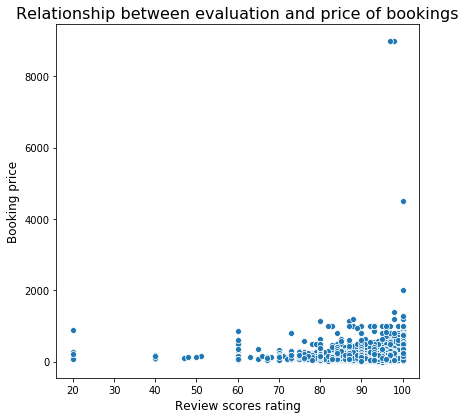

In [45]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.scatterplot(y="price_float", x="review_scores_rating", data=df_training)
_ = plt.xlabel("Review scores rating", size=12)
_ = plt.ylabel("Booking price", size=12)
_ = plt.title("Relationship between evaluation and price of bookings", size=16)

Deleting prices above 2000:

In [46]:
df_training_noOutliers = df_training[df_training.price_float < 2000]

/Users/daniela/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 468x468 with 0 Axes>

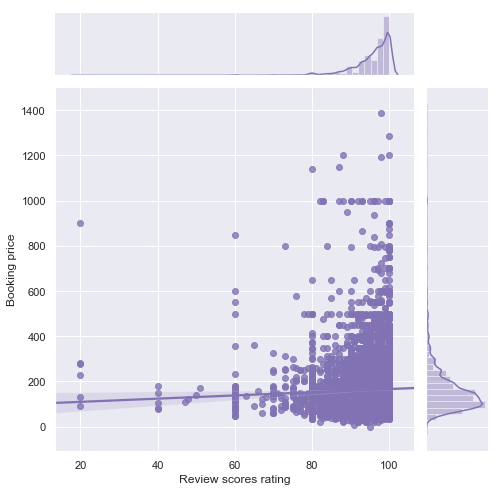

In [47]:
_ = plt.figure(figsize=(6.5, 6.5))
_ = sns.set(style="darkgrid")
_ = sns.jointplot(y="price_float", x="review_scores_rating", data=df_training_noOutliers,
                  kind="reg", truncate=False,
#                   xlim=(0, 60), ylim=(0, 12),
                  color="m", height=7)
_ = plt.xlabel("Review scores rating", size=12)
_ = plt.ylabel("Booking price", size=12)

There is a slight positive relationship between both variables and it makes sense that the highest accomodation prices imply a best quality of service. Perhaps, excelent evaluations are found in the most expensive and cheapest alternatives. Let's compute the Pearson correlation between ratings and score, avoiding nan values:

In [48]:
# Avoiding nan values using dropna()
df_ratings = df_training_noOutliers.dropna(subset=['review_scores_rating', 'price_float'])
print ('Pearson coefficient between Score Rating and Price = %.3f' %(pearson_r(x=df_ratings.review_scores_rating, y=df_ratings.price_float)))

Pearson coefficient between Score Rating and Price = 0.038


### Let's start analyzing how the different variables impact separately the booking prices:

/Users/daniela/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/daniela/anaconda3/lib/python3.7/site-packages/numpy/lib/histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


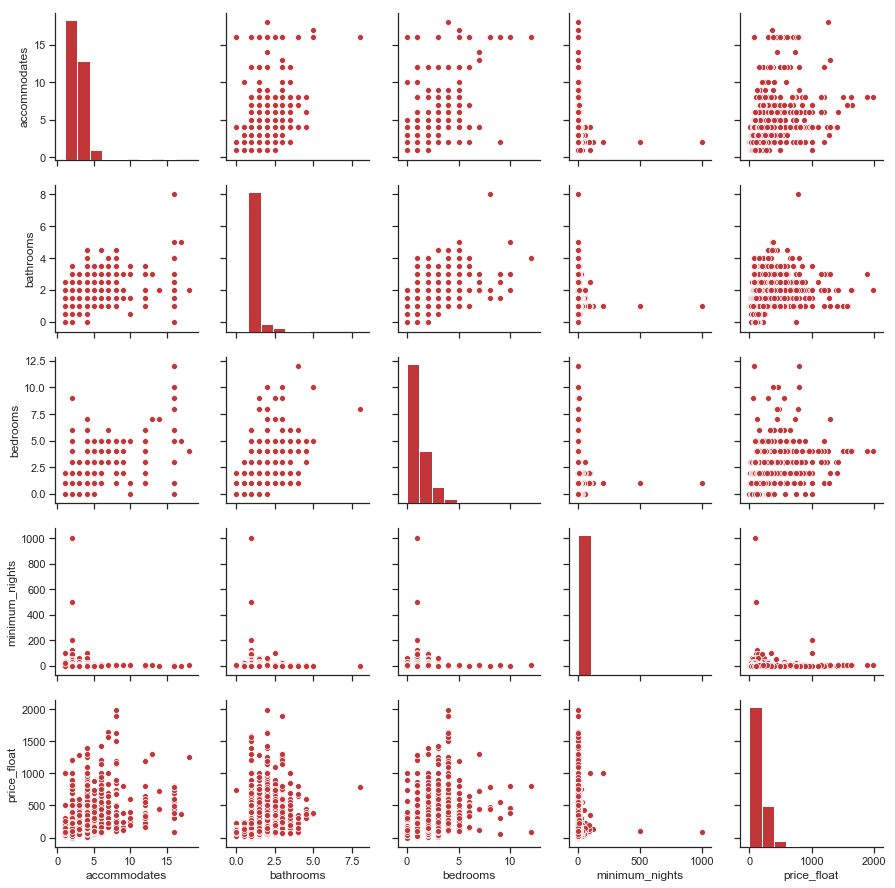

In [49]:
_ = sns.set(style="ticks", palette='RdBu', color_codes=True)
_ = sns.pairplot(df_training_noOutliers, vars=['accommodates', 'bathrooms', 'bedrooms', 'minimum_nights', 'price_float'])

It seems that the number of accommodates, bathrooms and bedrooms have positive relationships with the price, with Pearson correlations of 0.472, 0.318 and 0.426 respectively. Perhaps, they are correlated between them too. For instances, the Pearson correlation between `Accommodates` and `Bedrooms` is 0.723. Considering all of them in a linear model could generate a poor performance causing non-zero variance in the residuals and a high multicollinearity coefficient. The selected variables must be independent netween them to avoid that.

In [50]:
# Avoiding nan values using dropna()
df_accom = df_training_noOutliers.dropna(subset=['accommodates', 'price_float'])
print ('Pearson coefficient between Accommodates and Price = %.3f' %(pearson_r(x=df_accom.accommodates, 
                                                                               y=df_accom.price_float)))

df_bath = df_training_noOutliers.dropna(subset=['bathrooms', 'price_float'])
print ('Pearson coefficient between Bathrooms and Price = %.3f' %(pearson_r(x=df_bath.bathrooms, 
                                                                               y=df_bath.price_float)))

df_bed = df_training_noOutliers.dropna(subset=['bedrooms', 'price_float'])
print ('Pearson coefficient between Bedrooms and Price = %.3f' %(pearson_r(x=df_bed.bedrooms, 
                                                                               y=df_bed.price_float)))

df_AccomBath = df_training_noOutliers.dropna(subset=['accommodates', 'bathrooms'])
print ('Pearson coefficient between Accommodates and Bathrooms = %.3f' %(pearson_r(x=df_AccomBath.accommodates, 
                                                                               y=df_AccomBath.bathrooms)))

df_BedBath = df_training_noOutliers.dropna(subset=['bedrooms', 'bathrooms'])
print ('Pearson coefficient between Bedrooms and Bathrooms = %.3f' %(pearson_r(x=df_BedBath.bedrooms, 
                                                                               y=df_BedBath.bathrooms)))

df_AccomBed = df_training_noOutliers.dropna(subset=['accommodates', 'bedrooms'])
print ('Pearson coefficient between Accommodates and Bedrooms = %.3f' %(pearson_r(x=df_AccomBed.accommodates, 
                                                                               y=df_AccomBed.bedrooms)))

Pearson coefficient between Accommodates and Price = 0.472
Pearson coefficient between Bathrooms and Price = 0.318
Pearson coefficient between Bedrooms and Price = 0.426
Pearson coefficient between Accommodates and Bathrooms = 0.379
Pearson coefficient between Bedrooms and Bathrooms = 0.460
Pearson coefficient between Accommodates and Bedrooms = 0.723


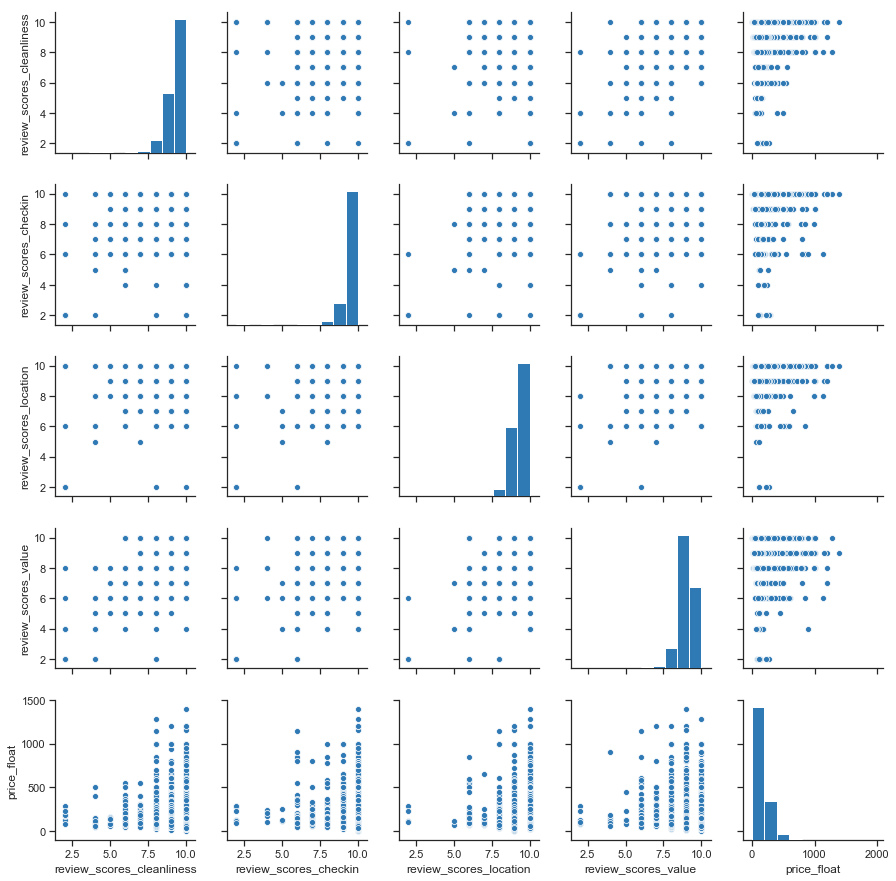

In [51]:
_ = sns.set(style="ticks", palette='RdBu_r')
_ = sns.pairplot(df_training_noOutliers, vars=['review_scores_cleanliness', 
                                               'review_scores_checkin',
                                               'review_scores_location', 
                                               'review_scores_value',
                                               'price_float'])  

And it's not surprise that the different review scores categories are linked with the price accomodations, as the average review score. Next, we check host `host_response_time_encode`, `host_response_rate_float`, `superhost` and `reviews_per_month` and `extra_people_float`:

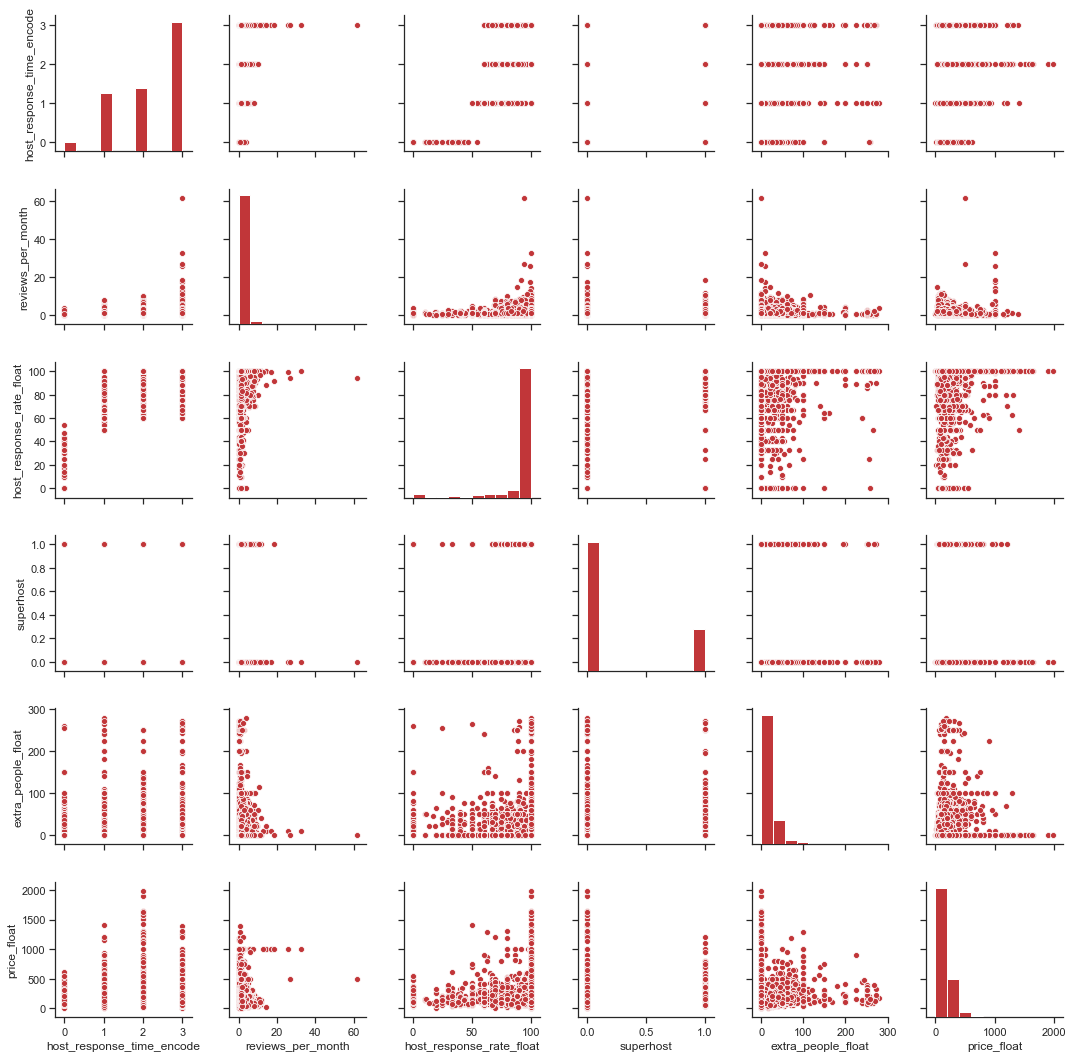

In [52]:
_ = sns.set(style="ticks", palette='RdBu', color_codes=True)
_ = sns.pairplot(df_training_noOutliers, vars=['host_response_time_encode', 
                                               'reviews_per_month', 
                                               'host_response_rate_float',
                                               'superhost',
                                               'extra_people_float', 
                                               'price_float'])  

Let's check the encode response time:

| Host Time Response | Encode |
| --- | --- |
| within an hour | 3 |
|  within a day | 1 |
|  within a few hours | 2 |
| a few days or more | 0 |

We observe that the accomodations where hosts response more quicky (within a few hours) concentrate the widest range of prices, including the more expensive bookings. Meanwhile, the bookings where hosts take more time in response have the range of lowest prices. It means that it exists a relation between host diligence and price of bookings.

On the other hands, `host_response_rate_float` is directly related to price of services. The impact of extra people is strong in cheapest and regular prices, but not for the more expensive bookings as we can see in the scatterplot that shows the relantionship between the `price_float` and `extra_people_float`. Curiosity, the highest prices are related to no super-hosts and as we can expect, the most expensive accomodations are not necessarily the most popular and they don't receive as much reviews per month as affordable bookings.

In [53]:
# Avoiding nan values using dropna()
df_rev = df_training_noOutliers.dropna(subset=['reviews_per_month', 'price_float'])
print ('Pearson coefficient between Reviews per Month and Price = %.3f' %(pearson_r(x=df_rev.reviews_per_month, 
                                                                                    y=df_rev.price_float)))

df_HostResp = df_training_noOutliers.dropna(subset=['host_response_rate_float', 'price_float'])
print ('Pearson coefficient between Host Response Rate and Price = %.3f' %(pearson_r(x=df_HostResp.host_response_rate_float, 
                                                                                y=df_HostResp.price_float)))

df_ExtraPeople = df_training_noOutliers.dropna(subset=['extra_people_float', 'price_float'])
print ('Pearson coefficient between Extra People Price and Price = %.3f' %(pearson_r(x=df_ExtraPeople.extra_people_float, 
                                                                                 y=df_ExtraPeople.price_float)))

Pearson coefficient between Reviews per Month and Price = -0.095
Pearson coefficient between Host Response Rate and Price = -0.002
Pearson coefficient between Extra People Price and Price = 0.058


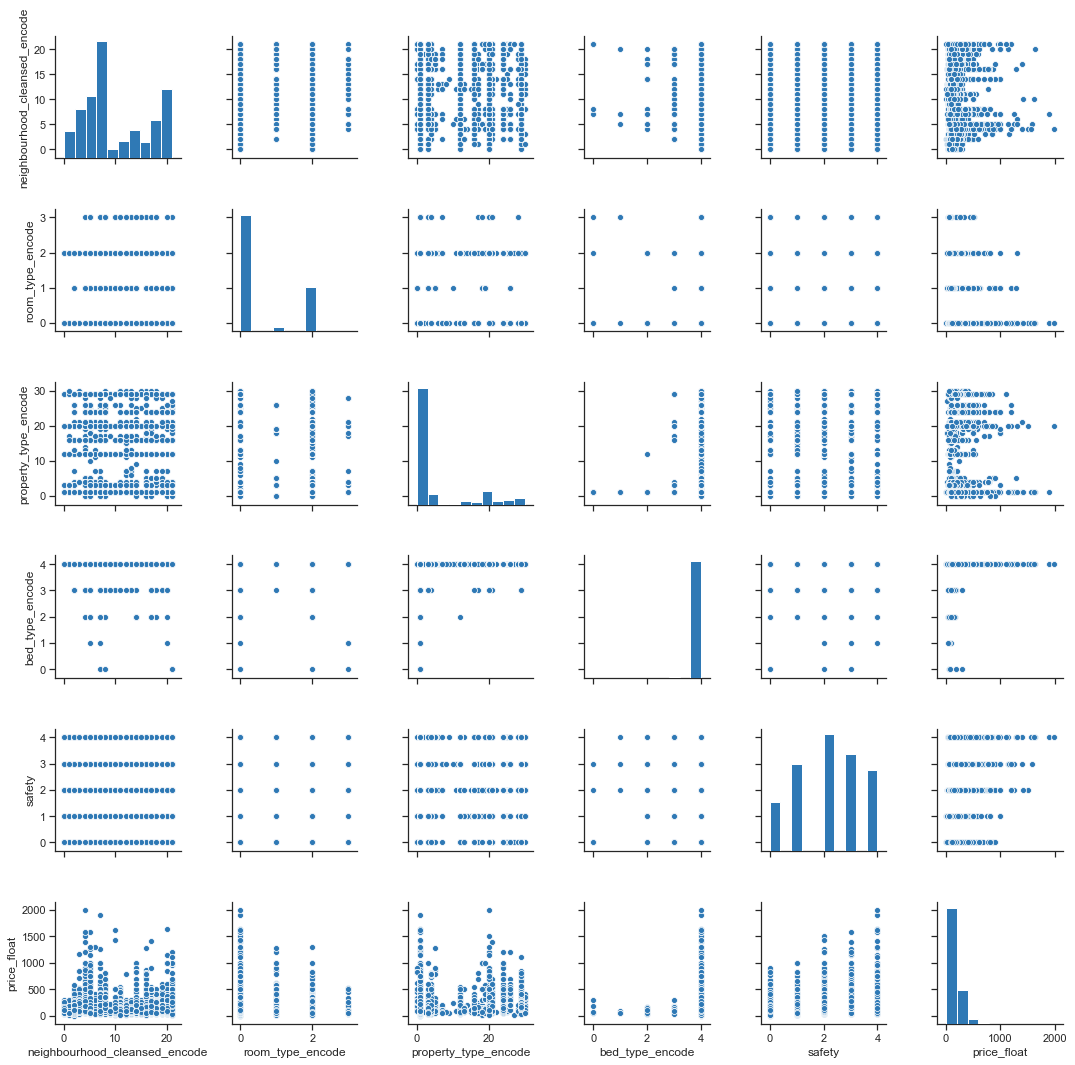

In [54]:
_ = sns.set(style="ticks", palette='RdBu_r')
_ = sns.pairplot(df_training_noOutliers, vars=['neighbourhood_cleansed_encode', 
                                               'room_type_encode', 
                                               'property_type_encode',
                                               'bed_type_encode',
                                               'safety', 
                                               'price_float'])  

Let's check the encode room and bed types:

| Room Type | Encode |
| --- | --- |
| Private room | 2 |
| Entire home/apt | 0 |
| Hotel room | 1 |
| Shared room | 3 |

| Bed Type | Encode |
| --- | --- |
| Real Bed| 4 |
| Futon  | 2 |
| Pull-out Sofa | 3 |
| Couch | 1 |
| Airbed | 0 |

The **type of room** represented by `room_type_encode`, impacts directly the price: entire homes or apartments are the most expensive accomodations, followed by hotel and private rooms (both of them with very similar ranges of prices). The more affordable options are shared rooms. The same analysis in **type of bed** results on highest prices in accommodations with *Real Beds*. The other alternatives -futons, pull-out sofa, couches and airbeds- offer more accesible prices in bookings.

**Safety** is one of the categories of amenities that we have defined previously. As we can observe, more safety items (as smoke detectors, carbon monoxide detectors and fire extinguishersI imply a wide range of prices including, subsequently, highest booking prices.

According to the scatterplots, there are correlations between some neighborhoods and property types with the price of the accommodations. 

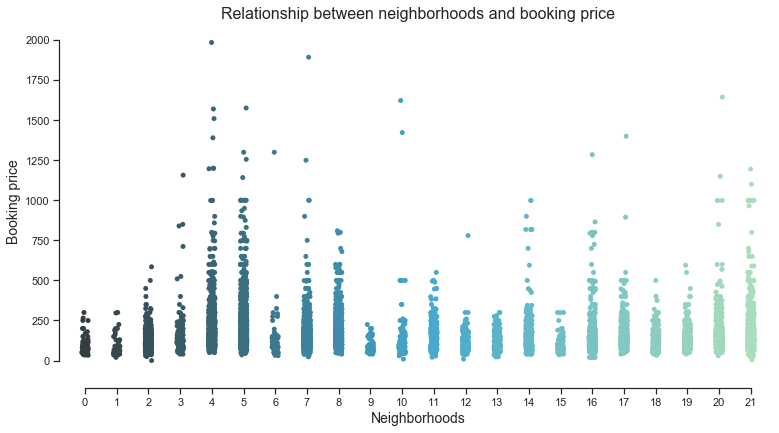

In [55]:
_ = plt.figure(figsize=(12.5, 6.5))
_ = sns.stripplot(x='neighbourhood_cleansed_encode', 
                  y='price_float',
                  data=df_training_noOutliers,
                  palette='GnBu_d')
_ = plt.xlabel('Neighborhoods', size=14)
_ = plt.ylabel('Booking price', size=14)
_ = plt.title("Relationship between neighborhoods and booking price", size=16)
_ = sns.despine(offset=10, trim=True)

| Neighbourhood | Encode |
| --- | --- |
| Bijlmer-Centrum | 0 |
| Bijlmer-Oost | 1 |
| Bos en Lommer | 2 | 
| Buitenveldert - Zuidas | 3 |
| Centrum-Oost | 4 |
| Centrum-West | 5 |
| De Aker - Nieuw Sloten | 6 |
| De Baarsjes - Oud-West | 7 |
| De Pijp - Rivierenbuurt | 8 |
| Gaasperdam - Driemond | 9 |
| Geuzenveld - Slotermeer | 10 |
| IJburg - Zeeburgereiland | 11 |
| Noord-Oost | 12 |
| Noord-West | 13 |
| Oostelijk Havengebied - Indische Buurt | 14 |
| Osdorp | 15 |
| Oud-Noord | 16 |
| Oud-Oost | 17 |
| Slotervaart | 18 |
| Watergraafsmeer | 19 |
| Westerpark | 20 |    
| Zuid | 21 |

Booking prices above 1000 € can be found in **Buitenveldert - Zuidas**, **Centrum-Oost**, **Centrum-West**, **De Baarsjes - Oud-West**, **Geuzenveld - Slotermeer**, **Oud-Noord**, **Oud-Oost**, **Westerpark** and **Zuid**. 
Other facts that we can check grouping the bookings by neighborhoods:

- Centrum-Oost and Centrum-West have the highest average booking price (above 200 €).
- Bijlmer-Centrum and Gaasperdam - Driemond have the lowest average booking price (below 100 €).

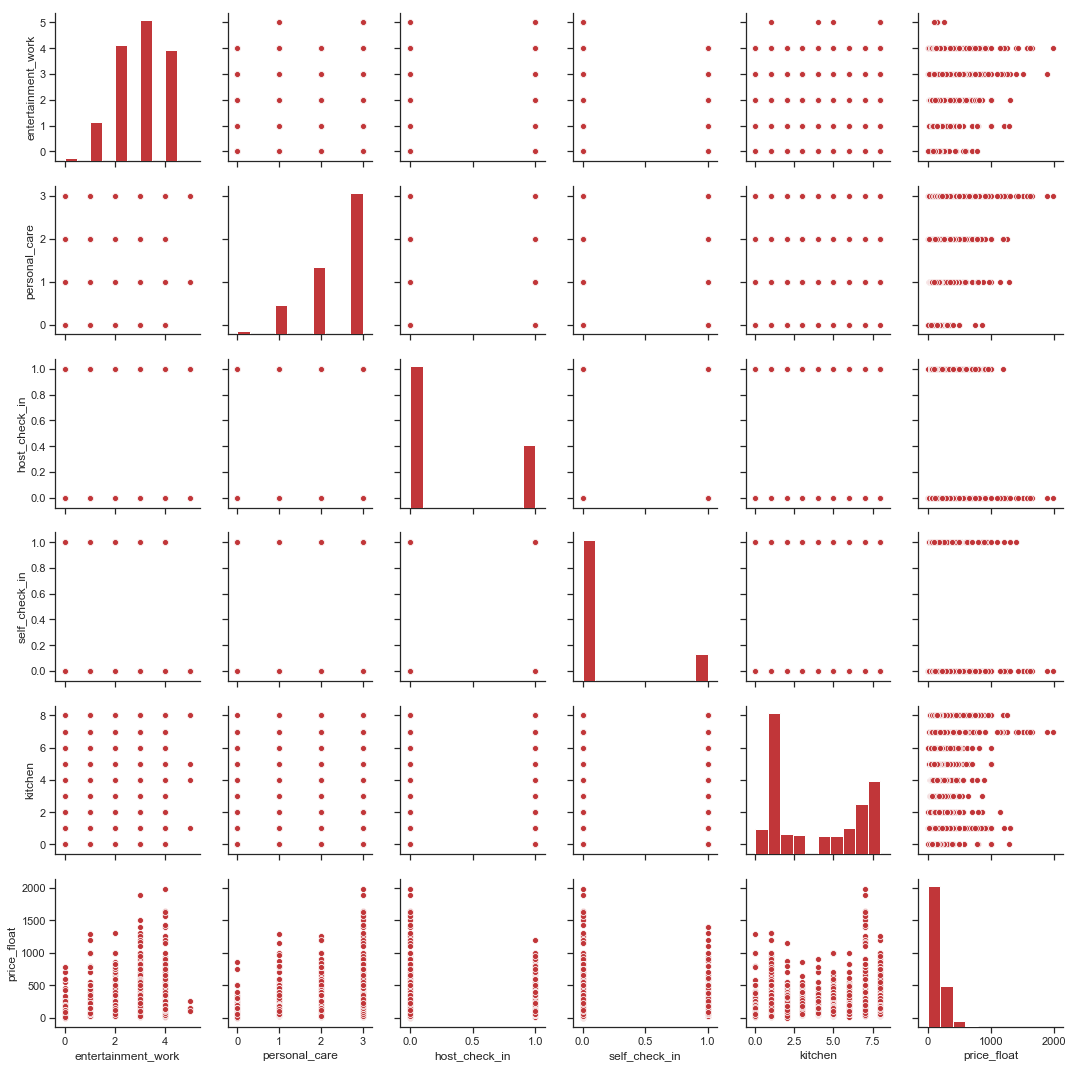

In [56]:
_ = sns.set(style="ticks", palette='RdBu')
_ = sns.pairplot(df_training_noOutliers, vars=['entertainment_work', 
                                               'personal_care', 
                                               'host_check_in',
                                               'self_check_in',
                                               'kitchen', 
                                               'price_float'])  

Some observations from the below plots:

- Host check and self check don't represent a plus in price of booking.
- It seems that the addition of elements in the kitchen, personal care and entertainment/work stuff (as laptop friendly environments, TV and Wifi) imply an increase in prices.

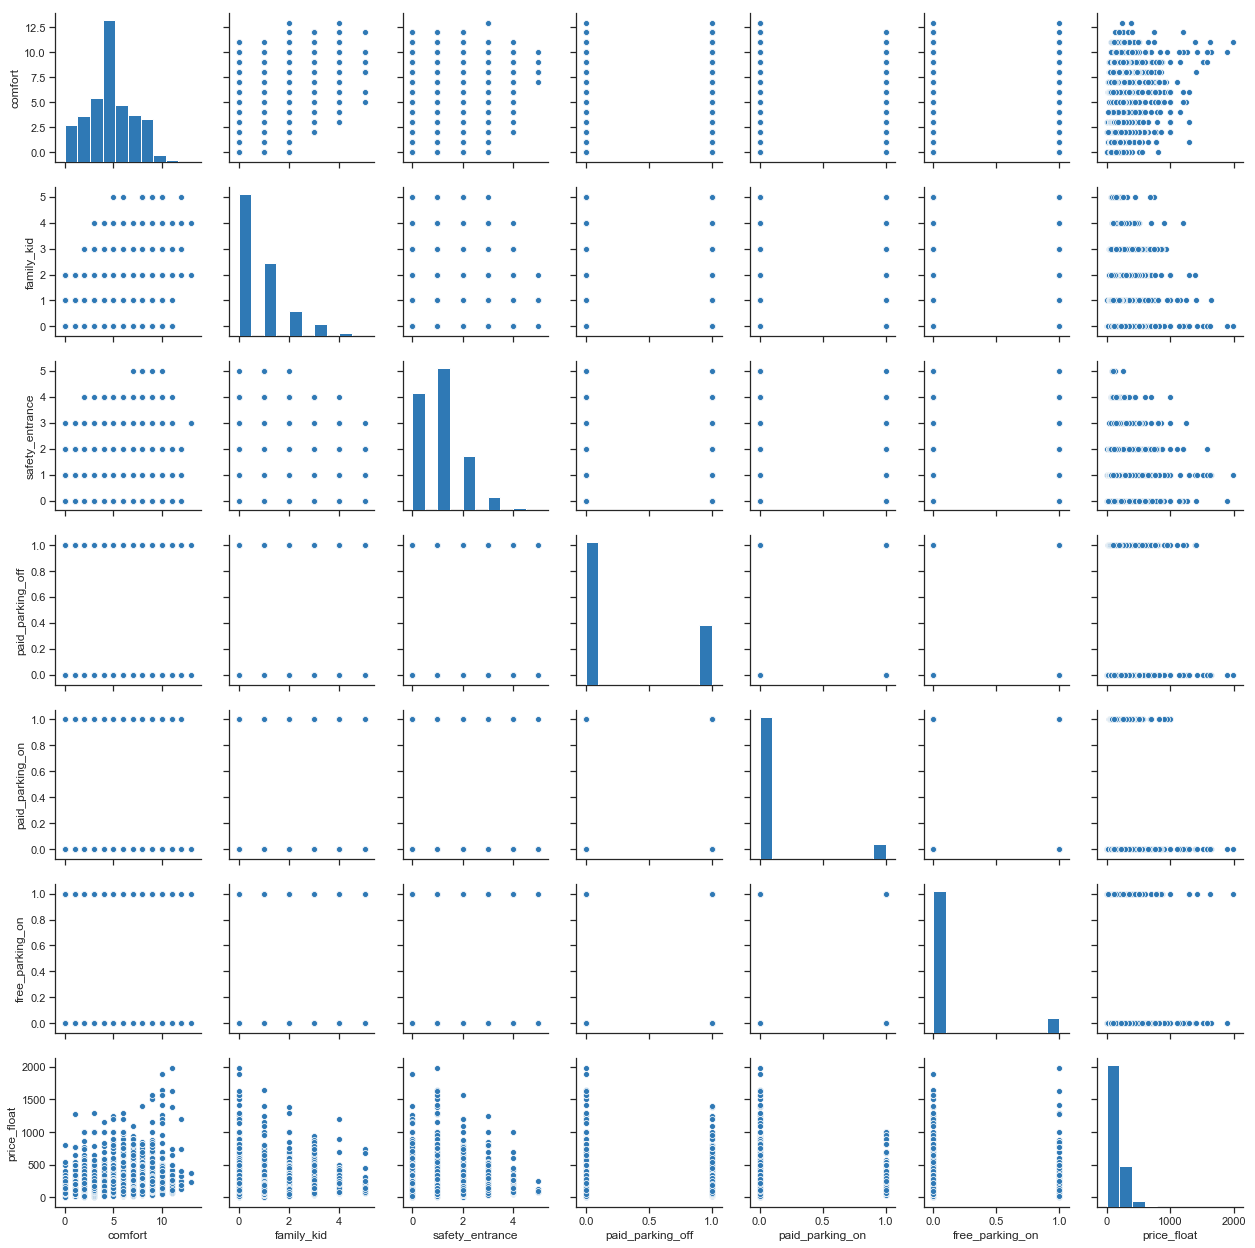

In [57]:
_ = sns.set(style="ticks", palette='RdBu_r')
_ = sns.pairplot(df_training_noOutliers, vars=['comfort', 
                                               'family_kid', 
                                               'safety_entrance',
                                               'paid_parking_off',
                                               'paid_parking_on', 
                                               'free_parking_on',
                                               'price_float'])  

**Comfort items** (like washers, stoves, irons, hot water, bed lines, air conditioning and hangers) impact directly the booking prices. On the other hand, the addition of more **family/kid** stuff seems affect negatively the ranges of prices. The age group or traveling purposes could explain that. It's reasonable to think that business trips or young people traveling with friends, partners are not traveling with their whole family and they don't require kid, pet and family friendly extra amenities.

What about **parking**?
- Free parking doesn't increase the price of bookings.
- Paid Parking in/out the properties don't seem justify increase on prices.

## Part 3: Linear Regression

In [58]:
# Import regression modules
import statsmodels.api as sm
from statsmodels.formula.api import ols

In [59]:
df_training_noOutliers.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10668 entries, 0 to 10675
Data columns (total 51 columns):
host_response_time                              10668 non-null object
neighbourhood_cleansed                          10668 non-null object
room_type                                       10668 non-null object
property_type                                   10668 non-null object
accommodates                                    10668 non-null int64
bathrooms                                       10665 non-null float64
bedrooms                                        10659 non-null float64
beds                                            10646 non-null float64
bed_type                                        10668 non-null object
minimum_nights                                  10668 non-null int64
maximum_nights                                  10668 non-null int64
has_availability                                10668 non-null object
availability_30                                 106

In [60]:
df = df_training_noOutliers.dropna()

In [61]:
df.drop(columns=['host_response_time', 'neighbourhood_cleansed', 'room_type', 'property_type', 'bed_type', 'has_availability'], inplace=True)

/Users/daniela/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [62]:
df.head()

,accommodates,bathrooms,bedrooms,beds,minimum_nights,maximum_nights,availability_30,availability_60,availability_90,availability_365,...,personal_care,host_check_in,self_check_in,kitchen,comfort,family_kid,safety_entrance,paid_parking_off,paid_parking_on,free_parking_on
0,2,1.5,1.0,2.0,3,15,0,0,0,0,...,3,1,1,0,6,1,4,1,1,0
1,2,1.0,1.0,1.0,1,1000,4,21,51,198,...,2,1,0,1,3,0,0,1,0,0
2,3,1.0,1.0,1.0,14,60,2,26,26,71,...,3,0,0,1,8,1,2,0,0,0
3,2,1.0,1.0,1.0,2,730,16,43,69,251,...,3,0,1,0,3,0,1,0,0,0
4,2,1.0,1.0,1.0,2,1825,0,2,10,134,...,3,1,0,1,4,0,2,0,0,0


In [74]:
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.metrics import mean_squared_error

In [69]:
X = df.drop(columns='price_float')
y = df.price_float

In [70]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=21)

In [71]:
#Inspecting performance adding estimators:
model = XGBRegressor(colsample_bytree=0.4,
                 gamma=0,                 
                 learning_rate=0.07,
                 max_depth=3,
                 min_child_weight=1.5,
                 n_estimators=10000,                                                                    
                 reg_alpha=0.75,
                 reg_lambda=0.45,
                 subsample=0.6,
                 seed=42)

In [ ]:
model.fit(X_train, y_train) 
preds = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, preds))